# Cohesive zone modelling of debonding and bulk fracture
$\newcommand{\bu}{\boldsymbol{u}}\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bn}{\boldsymbol{n}}
\newcommand{\bt}{\boldsymbol{t}}\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\jump}[1]{[\![#1]\!]}$

This numerical tour will show how we can formulate a cohesive fracture model with FEniCS. We adopt here an intrinsic cohesive zone model where cohesive elements are considered along all internal facets of the mesh. We will use for this purpose a Discontinuous Galerkin interpolation of the displacement field. The reader can also refer to [[HAN15]](#References) for a related work. 


The problem that we consider is a heterogeneous elastic plate with cohesive elements along the interface. The left part of the plate is fixed whereas the right part is subjected to an imposed displacement $\bu=(u(t), 0)$.



## Traction-separation law

Cohesive zone models are interface elements characterized by a discontinuous displacement and are able to transmit forces through the interface. The link between the interface opening (displacement jump) $[\![\bu]\!]$ and the traction $\bT$ is given by the choice of a specific constitutive law, usually refered to as a *traction-separation* law.

Among the many models available in the literature, we choose here one of the simplest ones, namely an exponential traction separation law given by:

\begin{equation}
\bT(\jump{\bu}) = \dfrac{G_{\text{c}}}{\delta_0^2}\exp(-g_{max}/\delta_0)\jump{\bu}
\end{equation}

where $g_{max}$ is the maximum effective opening displacement given by:

\begin{align}
g_{max}(t)&:=\max_{t'\in[0;t]} g(t') \\
g(t) &:= \sqrt{[\![u_n(t)]\!]^2+\beta[\![u_t(t)]\!]^2}
\end{align}

and where $\beta$ is a coupling coefficient which enables to link the normal opening $\jump{u_n} = \jump{\bu}\cdot\bn$ and the tangential opening $\jump{u_t}=\jump{\bu}\cdot\bt$ with $\bn$ (resp. $\bt$) being the unit normal (resp. tangential vector) of the considered interface.

Note that the above law works as a nonlinear "spring" model with a secant stiffness given by $\dfrac{G_{\text{c}}}{\delta_0^2}\exp(-g_{max}/\delta_0)$. In an unloading phase (i.e. \dot{g} < 0), the stiffness does not evolve and the interface acts as a linear elastic spring. In a loading phase for which \dot{g}>0 and $g = g_\text{max}$, we have a nonlinear elastic spring. For a purely normal opening $(\jump{u_t}=0)$ in a loading phase, we have:
\begin{equation}
T_n(\jump{u})=\dfrac{G_{\text{c}}}{\delta_0^2}\exp(-\jump{u}/\delta_0)\jump{u}
\end{equation}
which is maximum when $\jump{u}=\delta_0$ with a value $T_n(\delta_0) = \sigma_0 = \dfrac{G_{\text{c}}}{\delta_0^2}\exp(-1)$. $\delta_0$ therefore characterizes the critical opening for which the maximum strength $\sigma_0$ is reached. For $\jump{u}\gg \delta_0$, the stiffness vanishes and the cohesive element does not sustain any load anymore. Finally, when integrating the traction-separation law for $\jump{u}$ from 0 to $+\infty$, we see that the total dissipated surface energy is:
\begin{equation}
\text{Dissipation} = \int_0^{+\infty} T_n(\jump{u})d\jump{u} = G_\text{c}
\end{equation}
which is then the fracture energy spent when completely opening the interface.

The following script illustrates the pure normal opening behaviour of the exponential cohesive law along a few loading/unloading cycles.

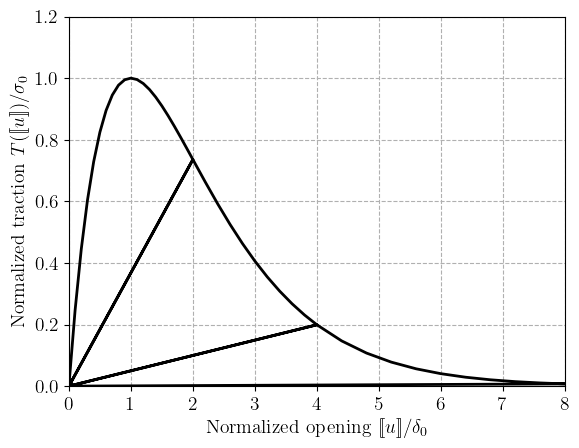

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

delta_0 = 1.
Gc = 1.
sig_0 = Gc/delta_0**2*np.exp(-1)
loading_cycles = [0, 2*delta_0, 0, 4*delta_0, 0, 8*delta_0, 0]
loading_list = [np.array([0])]
for start, end in zip(loading_cycles[:-1], loading_cycles[1:]):
    loading_list.append(np.linspace(start, end, 21)[1:])
loading = np.concatenate(loading_list)

g_max = 0
T = np.zeros_like(loading)
for (i, u) in enumerate(loading):
    g_max = max(abs(u), g_max)
    T[i] = Gc/delta_0**2*np.exp(-g_max/delta_0)*u/sig_0
    plt.plot(loading[:i+1], T[:i+1], '-k')
    plt.plot(loading[i], T[i], 'ok')
    plt.xlim(min(loading_cycles), max(loading_cycles))
    plt.ylim(0, 1.2)
    plt.xlabel(r"Normalized opening $[\![u]\!]/\delta_0$")
    plt.ylabel(r"Normalized traction $T([\![u]\!])/\sigma_0$")
    plt.show()
    clear_output(wait=True)

> Note that we do not distinguish here the tensile from the compressive regime. In practice, an asymmetric formulation should be considered, for instance with a high stiffness in compression to approximate a unilateral contact behaviour.

## Nonlinear resolution

The above traction-separation law is highly nonlinear. Newton-Raphson method is not necessarily extremely robust in such softening situations, especially in the presence of unstable crack propagation phases. For this reason, we prefer here to resort to a fixed-point iteration scheme in which, for a given load step, we solve an elastic displacement problem with $g_\text{max}$ being fixed to a previously known value:
\begin{equation}
\mathbf{K}^{(i)}\mathbf{U}^{(i+1)} = \mathbf{F}
\end{equation}
where $\mathbf{K}^{(i)}$ denotes the elastic stiffness matrix evaluated using the value of $g_\text{max}$ corresponding to the previous displacement $\mathbf{U}^{(i)}$.

We then update the value of $g_\text{max}$ using the newly computed displacement field $\mathbf{U}^{(i+1)}$. This process is iterated until convergence of the mechanical residual:
\begin{equation}
\|\mathbf{K}^{(i+1)}\mathbf{U}^{(i+1)} - \mathbf{F}\|_2 < \epsilon
\end{equation}

## FEniCS implementation

### Mesh and domains

We first import a Gmsh-generated mesh in which physical regions corresponding to the heterogeneities are labelled 2 and the matrix is labelled 1 (we plot them to check this). It also contains labels for the facets of the mesh, either exterior ones (labelled 1 and 2 for the left and right boundary respectively) or labelled 3 for the interface between the two materials. We define the volume integration measure `dx` based on the marked domains as well as the exterior facet surface measure `ds` and the inner facets surface measure `dS` based on the marked facets.

Note that we still need to define manually a `SubDomain` for where we will impose boundary conditions as seen later.

In [4]:
from mpi4py import MPI
import gmsh
from dolfinx.io import gmshio

# Create mesh using gmsh
L = 1.0
W = 0.5
R = 0.25
hsize = 0.66

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
gdim = 2
model_rank = 0
gmsh.model.add("Model")

gmsh.model.occ.addRectangle(0.0, 0.0, 0.0, L, W, tag=1)
gmsh.model.occ.addDisk(0.4, 0.0, 0.0, R, R, tag=2)
gmsh.model.occ.addDisk(0.6, W, 0.0, R, R, tag=3)
gmsh.model.occ.fragment([(gdim, 1)], [(gdim, 2), (gdim, 3)], removeObject=True)

gmsh.model.occ.synchronize()

gmsh.model.occ.remove([(gdim, 5), (gdim, 4)], recursive=True)

gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

volumes = gmsh.model.getEntities(gdim)

gmsh.model.addPhysicalGroup(gdim, [1], 1, name="Matrix")
gmsh.model.addPhysicalGroup(gdim, [2, 3], 2, name="Inclusions")


gmsh.model.addPhysicalGroup(gdim - 1, [3], 1, name="left")
gmsh.model.addPhysicalGroup(gdim - 1, [7], 2, name="right")
gmsh.model.addPhysicalGroup(gdim - 1, [1,5], 3, name="interface")
gmsh.model.mesh.generate(gdim)

domain, subdomains, facets = gmshio.model_to_mesh(
    gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim
)

gmsh.finalize()

In [10]:
import ufl
from dolfinx import mesh, fem
import dolfinx.fem.petsc
import dolfinx.nls.petsc


dx = ufl.Measure("dx", subdomain_data=subdomains)
ds = ufl.Measure("ds", subdomain_data=facets)
dS = ufl.Measure("dS", subdomain_data=facets, metadata={"quadrature_degree": 0})
n = ufl.FacetNormal(domain)

### Function spaces and functions

The variational formulation will be based on a discontinuous interpolation of the displacements, hence we define a **Discontinuous-Galerkin** ``"DG"`` space for the displacement. We will also need to compute quantities which live only on the facets of the mesh but may be discontinuous from one vertex to another e.g. the internal variables of the cohesive law (the maximum gap $g_\text{max}$ in the present case). The ideal solution would be here to use Quadrature elements on the mesh facets, which are unfortunately not available in FEniCS. We will instead use a ``Discontinuous Lagrange Trace`` (also known as ``HDiv Trace``) space which represents polynomials living on the facet of the meshes and which are discontinuous at the vertices. A piecewise constant FunctionSpace will also serve for defining material properties.


In [11]:
# space for discontinuous displacement
shape = (gdim,)
V_u = fem.functionspace(domain, ("DG", 1, shape))
# space for facet-based internal variables (maximum gap)
V_f = fem.functionspace(domain, ("CR", 1))
# space for piecewise constant material properties
V_0 = fem.functionspace(domain, ("DG", 0))

u = fem.Function(V_u, name="Displacement")
u_, du = ufl.TestFunction(V_u), ufl.TrialFunction(V_u)
g_max = fem.Function(V_f, name="Maximum_opening")

### Projection onto cells and facets

We then define some useful functions which will enable to project expressions on facet-based finite elements like ``V_f`` or on cell-based finite elements like ``V_0`` for instance. Both functions will be able to project a UFL expression. To define piecewise constant material properties, we also make such functions able to take, as an argument, a dictionnary of values of the following kind:

`{region_1: value_1,
  region_2: value_2,
        ...
  region_n: value_n}`
  
A cell/facet-wise constant function will then be obtained with `value_i` being affected to `region_i` where `region_i` is an `int` corresponding to a given marker of the cells or facets subdomains.

In [18]:
def mark_entities(domain, dim, entities_dict):
    """Mark entities of specified dimension according to a geometrical marker function

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    dim : int
        Dimension of the entities to mark
    entities_dict : dict
        A dictionary mapping integer tags with a geometrical marker function {tag: marker(x)}

    Returns
    -------
    entities_tag array
    """
    marked_values = []
    marked_entities = []
    # number of non-ghosted entities
    num_entities_local = domain.topology.index_map(dim).size_local
    # Concatenate and sort the arrays based on indices
    for tag, location in entities_dict.items():
        entities = mesh.locate_entities(domain, dim, location)
        entities = entities[entities < num_entities_local]  # remove ghost entities
        marked_entities.append(entities)
        marked_values.append(np.full_like(entities, tag))
    marked_entities = np.hstack(marked_entities)
    marked_values = np.hstack(marked_values)
    sorted_entities = np.argsort(marked_entities)
    entities_tags = mesh.meshtags(
        domain, dim, marked_entities[sorted_entities], marked_values[sorted_entities]
    )
    return entities_tags


def create_piecewise_constant_field(domain, cell_markers, property_dict, name=None):
    """Create a piecewise constant field with different values per subdomain.

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    cell_markers : MeshTag
        cell marker MeshTag
    property_dict : dict
        A dictionary mapping region tags to physical values {tag: value}

    Returns
    -------
    A DG-0 function
    """
    V0 = fem.functionspace(domain, ("DG", 0))
    k = fem.Function(V0, name=name)
    for tag, value in property_dict.items():
        cells = cell_markers.find(tag)
        k.x.array[cells] = np.full_like(cells, value, dtype=np.float64)
    return k


def facet_project(v, V):
    v_, dv = ufl.TestFunction(V), ufl.TrialFunction(V)
    a_form = ufl.inner(ufl.avg(v_), ufl.avg(dv)) * dS + ufl.inner(v_, dv) * ds
    if isinstance(v, dict):
        L_form = sum(
            [ufl.inner(ufl.avg(v_), val) * dS(reg) for (reg, val) in v.items()]
        )
    else:
        L_form = ufl.inner(ufl.avg(v_), v) * dS
        
    u = fem.Function(V)

    problem = fem.petsc.LinearProblem(
        a_form, L_form, u=u, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    problem.solve()

    return u

We illustrate how does `cell_project` works by building a cellwise constant function `E` representing the material Young modulus and taking a value of `3.09e3` on the matrix region (labelled 1) and `10e3` on the inclusion region (labelled 2).  We do the same for the Poisson ratio and then define the functions for the bulk elastic constitutive equation.

In [19]:
E = create_piecewise_constant_field(domain, subdomains, {1: 3.09e3, 2: 10e3})
nu = create_piecewise_constant_field(domain, subdomains, {1: 0.25, 2: 0.4})

lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)


def eps(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(eps(v)) * ufl.Identity(gdim) + 2 * mu * eps(v)

We now use the `facet_project` function to define a function on the facet space `V_f` which will take physical values on the region 3 corresponding to the interface and higher ones on the facets of the bulk domain, that is region 0. 

Note that, UFL requires to restrict facet functions when used in forms. We therefore use the `avg` function to obtain a restricted expression (`(+)` or `(-)` would also have worked in this case).

In [20]:
Gc_list = {-1: 0.5, 3:1.5}
Gc = facet_project(Gc_list, V_f)
print(set(Gc.x.array))
sig_list = {-1: 400., 3: 50.0}
sig_max = ufl.avg(facet_project(sig_list, V_f))

{0.5, 0.5000000000000001, 2.775557561562892e-17, 0.5000000000000002, 1.6999999999999995, 1.7000000000000008, 0.8000000000000002, 0.0, 0.7999999999999998, 1.9999999999999998, 2.0, 1.6999999999999966, 1.7000000000000024, 1.9825411154020653e-17, 1.9825411154020656e-17, 0.8000000000000009, 2.3129646346357432e-17, 0.7999999999999988}


### Traction-separation law

We then define various functions which will serve for expressing the cohesive law.

In [ ]:
delta_0 = Gc/sig_max/exp(1)
beta = Constant(2.)


def normal_opening(v, n):
    return dot(v, n)
def tangential_opening(v, n):
    return v - normal_opening(v, n)*n
def effective_opening(v, n):
    return sqrt(normal_opening(v, n)**2+beta**2*tangential_opening(v, n)**2)
def T(opening, g_max):
    return Gc/delta_0**2*exp(-g_max/delta_0)*opening

### Dirichlet boundary conditions

Here, we define the Dirichlet boundary conditions consisting here of fixed displacement on the left part and imposed displacement $(t,0)$ on the right boundary. Note that since we use DG discretization of the displacement field, the way to search for the dofs in the `DirichletBC` function must be enforced to be `"pointwise"` (see [this comment](https://fenicsproject.org/qa/1905/dirichlet-boundary-condition-fail-in-dg-simulation/)). This forbids the use of a `SubDomain` when defining the region in the corresponding `DirichletBC`. As a result, we need to manually locate the boundary with a Python function.

Finally, we will also need to impose the homogeneous version of the boundary conditions (i.e. with imposed displacements equal to zero). To do so in a generic fashion, we create a list of copies of the previous `DirichletBC` and use the `homogenize` method.

In [ ]:
DU = Expression(("t", "0"), t=0, degree=0)
bc = [DirichletBC(V_u, Constant((0., 0.)), Left, method="pointwise"),
      DirichletBC(V_u, DU, Right, method="pointwise")]
bc0 = []
for bci in bc:
    bch = DirichletBC(bci)
    bch.homogenize()
    bc0.append(bch)

### Variational form and linear solver

The variational form is now formulated as: Find $\bu\in V$ such that:
\begin{equation}
\int_{\Omega} \boldsymbol{\sigma}(\bu):\boldsymbol{\varepsilon}(\bv)d\Omega + \int_{\Gamma} \boldsymbol{T}([\![\bu]\!],g_{max})\cdot[\![\bv]\!] dS = F_{ext}(\bv) \quad \forall \bv \in V
\end{equation}

where $F_{ext}$ is the work of applied external loads (zero in the present example), $\Omega$ denotes the domain and $\Gamma$ the cohesive interfaces which are located here across all elements and, in particular, on the interface. For fixed $g_{max}$, the problem is linear and will be solved as such. Once a new displacement has been found, $g_{max}$ will be updated until convergence for a given load step.

In [ ]:
a = inner(sigma(du), eps(u_))*dx + inner(T(jump(du), avg(g_max)), jump(u_))*dS
Fext = Constant(0)*u_[0]*dx

lin_problem = LinearVariationalProblem(a, Fext, u, bc)
lin_solver = LinearVariationalSolver(lin_problem)
lin_solver.parameters["linear_solver"] = "mumps"

Calling FFC just-in-time (JIT) compiler, this may take some time.


### Load-stepping loop

The load stepping loop is now started with progressively applied imposed displacement. For each load step, an inner fixed-point iteration loop is performed to update the maximum opening and compute the new displacement until convergence. Convergence is measured from the residual of the above variational formulation (we use `action` to compute the action of the bilinear form in the solution). After assembling this residual, we need to account for boundary conditions using their homogeneous version.

At the end of each time step, the total resulting force on the right boundary is computed as well as $\int_{\Gamma}g_\text{max} dS$ as a measure of opening on a surface $\Gamma$. In the following, $\Gamma$ will either correspond to the interface facets or the internal bulk facets. In this post-processing computation, we consider only facets for which damage has already started, to avoid accounting elastic opening of non-damaged interfaces. We use a threshold of $g_\text{max} > \delta_0/10$ to consider that a facet has started to damage.


In [ ]:
Nincr = 60
Niter_max = 200
tol = 1e-4
opening = [[0, 0]]
Force = [0]
iterations = [0]

loading = np.linspace(0, 0.06, Nincr+1)


file_name = "czm_results.xdmf"
if os.path.isfile(file_name):
    os.remove(file_name)
    os.remove(file_name.replace(".xdmf", ".h5"))
    print("File hase been found and deleted.")

ffile = XDMFFile(file_name)
ffile.parameters["flush_output"] = True
ffile.parameters["functions_share_mesh"] = True
for (i, t) in enumerate(loading[1:]):
    print("Load step", i+1)
    DU.t = t
    nRes = 1.
    j = 0
    while j < Niter_max:
        lin_solver.solve()
        g_max.assign(facet_project(effective_opening(jump(u), n("-")), V_f))
        Res = assemble(action(a, u) - Fext)
        for bci in bc0:
            bci.apply(Res)
        nRes = Res.norm("l2")
        j += 1
        print("    Iteration {} | Residual: {}".format(j, nRes))
        if nRes < tol:
            break
    else:
        raise ValueError(
            "Fixed-point solver did not converge in less than {} iterations".format(Niter_max))
    iterations.append(j)
    clear_output(wait=True)

    Force.append(assemble(sigma(u)[0, 0]*ds(2)))
    carac_function = conditional(gt(avg(g_max), delta_0/10), 1, 0)
    opening.append([assemble(carac_function*avg(g_max)*dS(k)) for k in [3, 0]])

    ffile.write_checkpoint(u, "Displacement", i, append=True)

ffile.close()

Load step 60
    Iteration 1 | Residual: 1.7988890216671176e-06


In the above implementation, displacement fields have been saved in an XDMF file for Paraview visualization. 

> Note that Paraview cannot read DG-1 functions when using `write` as they will be automatically projected onto a CG-1 space. To read arbitrary discontinuous Lagrange elements, we need to use `write_checkpoint`. We also use the `append=True` keyword to append every time step to the same file. For this reason, we also need to delete the file at the beginning of the simulation if the file already exists. Otherwise, current time steps will be appended to the results of a previous simulation.

### Force-displacement and opening evolutions

As showcased in the initial GIF animation, the matrix/inclusion interface first starts to open almost elastically, then a sudden drop in the force-displacement curve corresponds to the unstable debonding of a large portion of both interfaces. The remaining load-carrying part of the structure then continues to stretch until a sudden final fracture of the central region.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


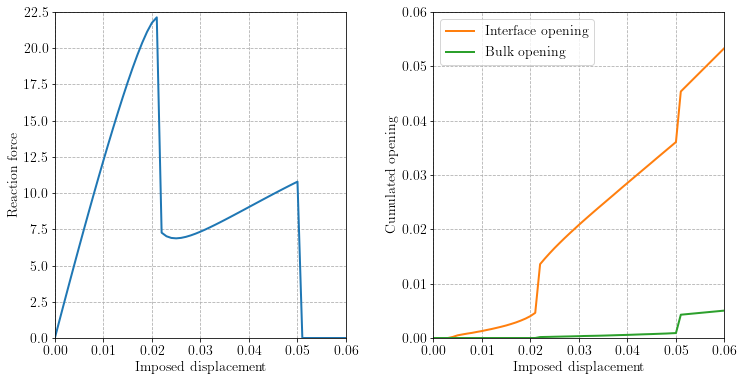

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loading, Force)
plt.xlabel("Imposed displacement")
plt.ylabel("Reaction force")
plt.subplot(1, 2, 2)
plt.plot(loading, np.asarray(opening)[:, 0], '-C1', label="Interface opening")
plt.plot(loading, np.asarray(opening)[:, 1], '-C2', label="Bulk opening")
plt.legend()
plt.xlabel("Imposed displacement")
plt.ylabel("Cumulated opening")
plt.subplots_adjust(wspace=0.3)
plt.show()

## References

[HAN15] Hansbo, P., & Salomonsson, K. (2015). A discontinuous Galerkin method for cohesive zone modelling. Finite Elements in Analysis and Design, 102, 1-6.